
# Code Intent Prediction
## With Applied Machine Learning Techniques
***
### Justin Hugh
#### Data Science Diploma Candidate, BrainStation
##### December 18, 2020

***

## Table of Contents
#### [ 1.0 - Introduction](#1.0---Introduction)
- [ 1.1 - Problem](#1.1---Problem)

#### [ 2.0 - Background](#2.0---Background)
- [ 2.1 - Stack Overflow](#2.1---Stack-Overflow)
- [ 2.2 - Packages and Libraries](#2.2---Packages-and-Libraries)

#### [ 3.0 - Limitations and Assumptions](#3.0---Limitations-and-Assumptions)

#### [ 4.0 - The Data](#4.0---The-Data)
- [ 4.1 - Sources of Data](#4.1---Sources-of-Data)  
    - [ 4.1.1 - CoNaLa](#4.1.1---CoNaLa)
    - [ 4.1.2 - Other Sources of Data](#4.1.2---Others-Sources-of-Data)

#### [ 5.0 - Exploratory Data Analysis](#5.0---Exploratory-Data-Analysis)  
- [ 5.1 - Importing Data](#5.1---Importing-Data)   
    - [ 5.1.1 - Importing CoNaLa Competition Data](#5.1.1---Importing-CoNaLa-Competition-Data)
        - [ 5.1.1.1 - Importing CoNala Training Data](#5.1.1.1---Importing-CoNaLa-Training-Data)
        - [ 5.1.1.2 - Importing CoNaLa Test Data](#5.1.1.2---Importing-CoNaLa-Test-Data)
    - [ 5.1.2 - DataFrames from CoNaLa Competition Data](#5.1.2---DataFrames-from-CoNaLa-Competition-Data)
    
    
&
&
&
&
    
   
    - [ 5.1.2 - CoNaLa Mined Data](#CoNaLa-Mined-Data)
        - [ 5.1.2.1 - Proposed `prob` Cutoff](#Proposed-prob-Cutoff)
- [ 5.2 - Combining Data](#Combining-Data) &&& Double Check This!
    - [ 5.2.1 - Cleaning Data](#Cleaning-Data)
- [ 5.3 - Vectorizing Text Data](#Vectorizing-Text-Data) && Should this go before combining?
    - [ 5.3.1 - Simple Bag of Words Vectorization](#Simple-Bag-of-Words-Vectorization)
        - [ 5.3.1.1 - Vectorizing `conala_train_df` with Bag of Words](#Vectorizing-conala_train_df-with-Bag-of-Words)
        - [ 5.3.1.2 - Vectorizing `conala_mined_df` with Bag of Words](#Vectorizing-conala_mined_df-with-Bag-of-Words)
        - [ 5.3.1.3 - Comparing Vectorized `conala_mined_df` and `conala_trained_df`](#Comparing-Vectorized-conala_mined_df-and-conala_trained_df)
        - [ 5.3.1.4 - Combining DataFrames](#Combining-DataFrames)
        - [ 5.3.1.5 - Dimension Reduction of Bag of Words](#Dimension-Reduction-of-Bag-of-Words)
            - [ 5.3.1.5.1 - PCA on Bag of Words](#PCA-on-Bag-of-Words)
            - [ 5.3.1.5.2 - T-SNE on Bag of Words](#T-SNE-on-Bag-of-Words)
    - [ 5.3.2 - Word2Vec Text Vectorization](#Word2Vec-Text-Vectorization)
        - [ 
        
- [ Intent Paradigms](#Intent-Paradigms)  

#### [ Modelling and Analysis](#Modelling-and-Analysis)

#### [ Next Steps](#Next-Steps) 

#### [ Conclusion](#Conclusion)

#### [ References](#References)

***

# 1.0 - Introduction
[[Back to TOC]](#Table-of-Contents)

This report and project have been conducted as a final requirement and submission for the BrainStation Data Science Bootcamp. I participated in the Toronto Fall 2020 cohort. The duration of this project was about 5 weeks of development, ending December 20, 2020. 

This workbook constitutes only the code required to conduct the final approach which was taken in order to address the problem. A wide range of exploration and alternative preprocessing/modelling approaches were conducted, but these have been excluded from this notebook for brevity. Supplementary information is provided alongside this notebook which speaks to these other conducted approaches.

## 1.1 - Problem
[[Back To TOC]](#Table-of-Contents)

Software and code are becoming present nearly everywhere in our daily lives both personal and professional. Whether it helps us accomplish complex and massive tasks, or powers the applications and products we rely on, the digital world is expanding. Yet, only a fraction of us are literate in code, and even among those of us who are, there are a wide range of languages and frameworks so no one is familiar with it all, and mistakes or misinterpretations can be made even on languages we're familiar with. 

I propose a model which could predict the intent or purpose of a sample of code. A tool like this would helpful in understanding more of the world around us and would be hugely impactful for:  
- Education. Making code more accessible and interpretable.  
- Security. Identifying code with malicious intent.  
- Development. Providing contextual tooltips, suggestions, resources.   

The goal of this project is to develop an ML model which employs NLP tools to interpret a samples of code and make a prediction as to its intent.

***

# 2.0 - Background
[[Back To TOC]](#Table-of-Contents)

Currently, there are no commercialized or productized options available to a programmer who is looking to understand code that they are unable to interpret, whether in an academic, professional, or hobbyistic setting. 

For this project, I conducted preliminary research in order to find alternatives or studies on the topic, and while some others have begun study on this problem, it seems that state of the art applications in the field can perform well in translating python code to pseudocode [[1]](#References). However at the moment there is no high-performing model, or model that can convert the code into an English description. This difficulty occurs because the structure and syntax of the two types of text (code and intent) are quite different from one another, whereas this difference is less pronounced between code and pseudocode. Being able to create pseudocode is a wonderful start to the problem, but is insufficient for my goal in making code more accessible. For many hobbyists or even professionals who do not program as their main function, pseudocode will not be a familiar or fully interprable format.

This will clearly be a difficult task, but I'm looking forward to learning and sharing more about the problem space in hopes of moving towards my goal myself, or sharing learning with others so that they can make their own progress on the matter.

Natural Language Processing (NLP) Models have seen very large recent acceleration as a result of the success of smart assistants, as well as the commoditization of computing power. With this, support for very powerful libraries and approaches in language modelling are widely available, and there is extensive research on the topic. Because there are so many resources in the area, and because there continues to be a heavy amount of momentum, this is a great time to apply these techniques to my difficult problem space.

Below I'll discuss other contexts surrounding the problems I'm tackling.

## 2.1 - Stack Overflow
[[Back To TOC]](#Table-of-Contents)

**Stack Overflow** is an online community for programmers [[2]](#References). The website provides a question and answer experience in which programmers can submit questions about how to accomplish various tasks or identify bugs in their code. Respondents to the queries are commonly other programmers who know of a solution or can provide helpful direction, often in the form of a code snippet. This website and service has become very widely popular and as a result hosts a large collection of code snippets, paired with a question/query. It is now one of the largest collections of coding knowledge online.

Much of the code examined and used in this project originally comes from a post on Stack Overflow.

## 2.2 - Packages and Libraries
[[Back To TOC]](#Table-of-Contents)

There's a wealth of openly available python packages and libraries which are indispensible in tackling Machine Learning problems. These are dependencies of this project and I'll import a number of those needed in this section.

In [ ]:
# Libraries for general array/dataframe use
import numpy as np 
import pandas as pd 

# Libraries for data visualization with python
import matplotlib.pyplot as plt
import seaborn as sns
# Magic function to help presentation of these visuals
%matplotlib inline

# Functions for saving and importing data
import pickle

# Data Processing/Transformation Packages
import json
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import BaggingClassifier

# Word Vectorization and Natural Language Processing Libararies
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import nltk

# Runtime tools and helpers
from tqdm import tqdm
import time 
import warnings
warnings.filterwarnings("ignore")

These libaries are quite commonly used and are all easily acquired with [ Conda](https://docs.conda.io/projects/conda/en/latest/user-guide/install/macos.html) [[3]](#References)

***

# 3.0 - Limitations and Assumptions
[[Back To TOC]](#Table-of-Contents)

In this section I'll recognize some of the limitiations and assumptions to the modelling and analysis I will conduct below. Those listed here are generally applicable to the project at large. Any that are more specifically applicable to a certain step are discussed at that point in the analysis.

- Some of this data is not current. The main sources of the data comes from a competition which was conducted in 2018. Software changes quite quickly and frequently. My model and this system's performance may be less applicable to presently written code, and will deprecate over time as libraries and languages are updated and the language, or prevalence of various functions adjusts to this.

- I assume the data set originating from the competition training data does not have known significant errors, such as incorrect application of code or erroneous syntax. If these are present in abundance, then this system's performance will have "learned" incorrect code application.  

- Developers are not uniquely identified in the data I've used. Not having this information restricts me from making more deep insights into code and intent on a developer-by-developer level which could potentially mean more accurate interpretations. Different developers can accomplish the same task by coding with quite different styles. However, not uniquely identifiying the developers is a good and necessary practice from a privacy and standpoint. If developers were uniquely identified in the data, this could potentially be used to reconstruct personal data, constituting a notable privacy concern.

- The amount of data that is used and analyzed in this project is quite restricted. This is largely as a result of limitations of computing resources and time. As a next step in this project, one of the first considerations should be expanding the amount of data analyzed.

***

# 4.0 - The Data
[[Back To TOC]](#Table-of-Contents)

This section will include notes about the sources of data used as inputs in this project. Where the data comes from, its characteristics, and how I intend to use it.

## 4.1 - Sources of Data
[[Back To TOC]](#Table-of-Contents)

To acquire the data used in this project, I conducted research, seeking sets of annotated code snippets. I found a good number of resources with much code available, but with varying characteristics. On one hand, I was able to find some well-structured and cleaned data, and on the other, I found large quantities of stored code, but either poorly formatted, or more difficult to process. 

I'll discuss below where I obtained the data.

### 4.1.1 - CoNaLa
[[Back To TOC]](#Table-of-Contents)

[_The Code/Natural Language Challenge (CoNaLa)_](https://conala-corpus.github.io/#dataset-information) is a challenge that was created by [_Carnegie Mellon University (CMU)_](https://www.cmu.edu/) along with [_NeuLab_](http://www.cs.cmu.edu/~neulab/) and [_STRUDEL Lab_](https://cmustrudel.github.io/) on May 31, 2018 in order to test systems for generating programs from natural language [[4]](#References). The original intent was to - given an english input such as "sort list x in reverse order" - have a system output such as `x.sort(reverse=True)` in Python. 

_CoNaLa_ is a competition with no end date, and the data are offered for use within the challenge itself, but also licensed for any other research on the intersection of code and natural languague, a use case which this project falls nicely into.

_CoNaLa_ provides a wealth of publicly available data which is well suited for the needs of this project including: 
- Training Data: Data crawled from _Stack Overflow_ with 2,379 training examples.
    - These data include user submitted queries, the corresponding code responses by other users on Stack Overflow. Each of these has been manually annotated with a revised intent field (the query rewritten to be more clear) by volunteers for the _CoNaLa_ competition.
- Test Data: 500 test examples. These have been curated by annotators.
    - These data were separated from the training data so that competitors could test their code with the same set. These are in the same format as the training data.
- Mined Data: Automatically-mined data with 600,000 examples. 
    - _CoNaLa_ also provides extra data to be considered if participants are interested. These were automatically scraped from Stack Overflow in pairs of query, and response. However, the quality and accuracy of the responses are not verified at all. Thus, there is no revised intent field.
    - A "probability" is provided with these data. This score was progammatically generated by the scraping protocol and indicates the level of relevance the scraped intent field (query) has to the code response.
- Links to other helpful and similar data sets:
    - [Django Dataset](https://ahcweb01.naist.jp/pseudogen/)  
    - [StaQC](https://github.com/LittleYUYU/StackOverflow-Question-Code-Dataset) 
    - [Code Docstring Corpus](https://github.com/EdinburghNLP/code-docstring-corpus)
        - These are simply links to other places were large amounts of code can be found, so very little cleaning or confirmation of its quality has been conducted. 

### 4.1.2 - Others Sources of Data
[[Back To TOC]](#Table-of-Contents)

Through the course of working on this project, it became quickly apparent when beginning to preprocess and preliminarily model with the data that I needed to work with a small sample of data. This is because the computing resources I had access to were restricted, and in order to complete the study within time constraints, I needed my models to train quickly, and without tying up large amounts of memory. For this reason, the CoNaLa Training Data and CoNaLa Test data discussed above were the only data sets which are used below. A priority next step to this project will be to acquire and clean a wider set of data and transfer the approach generated in this report to more data.

I've done a wealth of work in finding other sets of data that would be appropriate to incorporate in the future. These are left out of this report for brevity, but provided in the companion markdown file `other_data_sources.md`

I also made the decision to not include the CoNaLa Mined data further in this report after extensive exploration was conducted on that data. From that exploration I found that the data was for the most part of low quality that would harm or not improve the results of this report. Examples of the exploration conducted on this data and discussion on findings are included in the provided notebook, `conala_mined_data.ipynb`. 

***

# 5.0 - Exploratory Data Analysis
[[Back To TOC]](#Table-of-Contents)

The purpose of Exploratory Data Analysis (EDA) step is to familiarize myself with the data and determine whether it has missing values or other deficiencies. This step is also an opportunity to clean the data so it may be analyzed further, and peek at some of the more immediately evident insights of the data and parameters I'm working with. By the end of these activities, I'll have a cleaned set of data which is prepared for modelling and deeper analysis. 

## 5.1 - Importing Data
[[Back To TOC]](#Table-of-Contents)

Before conducting exploration, I'll have to load in the data to this notebook. The data I use below all came from the _CoNaLa_ competition introduced above, and so a singular approach for loading the data will be sufficient. In this section I'll outline the method I used for doing this. I'll also conduct the data import itself.

### 5.1.1 - Importing CoNaLa Competition Data
[[Back To TOC]](#Table-of-Contents)


Recall from the [**CoNaLa Section**](#CoNaLa) above, the Competition data is comprised of data crawled from Stack Overflow with 2,379 training examples, and 500 test examples. The data has been made conveniently available. 

This data can be accessed through direct downloaded by clicking this link: [CoNaLa Corpus v1.1 (.zip file, 52.1 MB)](http://www.phontron.com/download/conala-corpus-v1.1.zip). It's also linked on the [CoNaLa Competition Page](https://conala-corpus.github.io/).

This download produces a compressed `.zip` file. Once unzipped, the folder contians the data with training examples and the test examples stored in separate folders. Accordingly, I've loaded each of these into this notebook in a saparate step.

In order for the data to be loaded for use with this notebook, and for organization, the corresponding data has been moved into the `data` folder in the same directory as this notebook.

#### 5.1.1.1 - Importing CoNaLa Training Data
[[Back To TOC]](#Table-of-Contents)


I'll start first with the training data.

This data is provided in the format of a .json file, in a set of subfolders. I peeked at the data by opening the json file and viewing the text contained. A preview of what the data looks like is included below:

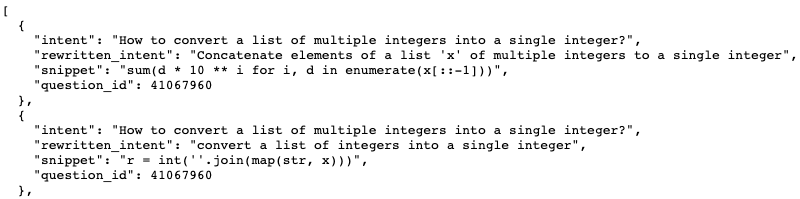

This looks like the data is contained in a list of JSON objects. This is great news, since this format is quite friendly for use with the `pandas` library. This will allow for conversion of this data into a DataFrame format which can be worked with in the upcoming process of data munging.

Knowing this, I can construct my data extraction process accordingly.

In [ ]:
# CoNaLa Training Data

# Open the json file, handle with `with` statement so the file is closed once finished
# load the contents which are contained as a json object.
with open('data/conala-corpus/conala-train.json') as f:
    # Instantiate conala_train_data to hold the data.
    conala_train_data = json.load(f)

In [ ]:
# Peek at the loaded data
conala_train_data

In [ ]:
# Check number of json objects in the list.
len(conala_train_data)

This variable successfully loaded the data in a similar format, that is as a list of json objects, or equivalently, a list of dictionaries. I'll move onto the Test data and take the same approach.

#### 5.1.1.2 - Importing CoNaLa Test Data
[[Back To TOC]](#Table-of-Contents)

Similarly, this data is provided in the format of a .json file, in a set of subfolders. I peeked at the data, and show a preview included below:

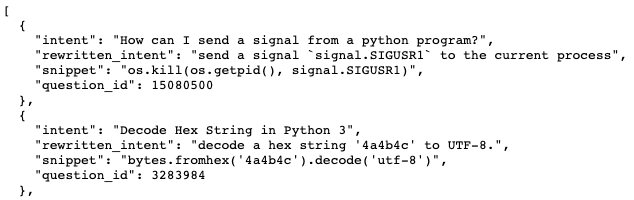

This is also a list of JSON objects.

In [ ]:
# CoNaLa Test Data

# Open file with `with` statement.
with open('data/conala-corpus/conala-test.json') as f:
    # Instantiate conala_test_data to hold the data.
    conala_test_data = json.load(f)

In [ ]:
# Peek
conala_test_data

In [ ]:
# Check number of json objects in the list.
len(conala_test_data)

This was also successful.

#### 5.1.2 - DataFrames from CoNaLa Competition Data
[[Back To TOC]](#Table-of-Contents)

In this section, I'll manipulate the data to be in a more workable format, namely a pandas DataFrame. Conveniently pandas includes a method `from_dict` which is able to ingest the json data in its current listed form and create a DataFrame from this.

In [ ]:
# Create DataFrames from the CoNaLa train and test sets, both from a list of dictionary objects
conala_train_df = pd.DataFrame.from_dict(conala_train_data)
conala_test_df = pd.DataFrame.from_dict(conala_test_data)

# Peek at the dfs
display(conala_test_df.head())
display(conala_train_df.head())

# Check Shapes of dfs
print(conala_train_df.shape)
print(conala_test_df.shape)

### Importing CoNaLa Mined Data
[[Back To TOC]](#Table-of-Contents)

- I assume the data set which I've modified from the *mined* data of the competition is adequately described by the "probability" it includes (discussed in more detail below). If the model which generates these probabilities is heavily flawed, then the result will be a poorly performing model as it is based on this data. Additionally, any bias which is included in the method for generating a probability score will feed forward into my own model, as this score was used to interpret the quality of the data.

Recall from the [**CoNaLa Section**](#CoNaLa) above, the CoNaLa Competition also provided a set of mined data. This is comprised of data crawled from Stack Overflow with about 600,000 examples. However, these examples have not been been curated by annotators like the other sets. This data therefore needs to be more scrutinized.  

These are included in the same direct download as the others, again available here: [CoNaLa Corpus v1.1 (.zip file, 52.1 MB)](http://www.phontron.com/download/conala-corpus-v1.1.zip).

This data is provided in the format of a .jsonl file, so slightly different than above. I peeked at the data, and show a preview included below:

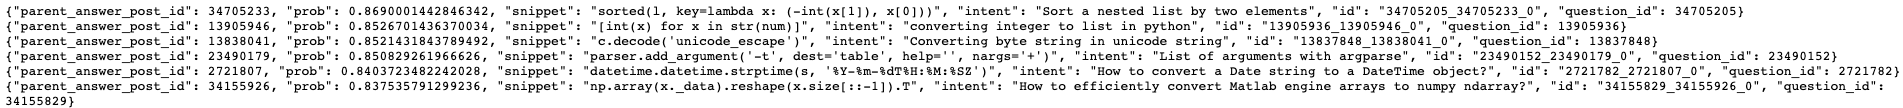

Notably, this data is not contained in a list object, but includes multiple json objects in sequence.

In [ ]:
# CoNala Mined Data

# This file is different in format from the other CoNaLa Competition Data, 
# and contains multiple json objects. We need to handle it differently.

# First instantiate an empty list, this will be used hold all of the dictionary objects as a list
# of dictionaries.
conala_mined_data_list = []

# Open file, loop through the json objects in the file, appending the list each time. 
with open('data/conala-corpus/conala-mined.jsonl') as f:
    for jsonObj in tqdm(f):
        code_dic = json.loads(jsonObj)
        conala_mined_data_list.append(code_dic)

In [ ]:
# Peek at the list created.
conala_mined_data_list[-5:]

This data is now in the same list of json objects format that the train and test data above were. It can be converted into a pandas DataFrame similarly.

Below I look briefly into the shape and contents of this DataFrame.

In [ ]:
# Convert list of json objets for mined data into pandas DataFrame
conala_mined_df = pd.DataFrame(conala_mined_data_list)

# Peek at the DataFrame for the mined CoNaLa data.
display(conala_mined_df.head())

# Check shape of the DataFrame
conala_mined_df.shape

Note that the index is not random, the records are sorted such that the probabilities decrease along the list. That is, the lower the rank of the index, the higher the probability score. To look more at the distribution of the probabilities included, the `pd.describe()` function is useful. 

In [ ]:
# Looking at the DataFrame's statistics for numerical columns.
# Drop the columns for which statistics are not meaningful.
conala_mined_df.drop(["parent_answer_post_id", "question_id"], axis=1).describe()

The `parent_answer_post_id` and `question_id` columns are not too meaninful since the numbers stored in these columns are nominal, so these were dropped in the above.

The statistics we see for the `prob` column is quite informative here. Of note, the mean probability is very low, at 6.4%, and even the 75th percentile is much lower than expected at 7.5%. This means there are far fewer records here where the code snippet is confidently associated with an intent than I was hoping for. This problem is discussed in the study which produced this mined code: 

> existing heuristic methods (e.g., pairing the title of a post with the code in the accepted answer) are limited both in their coverage and the
correctness of the NL-code pairs obtained.

To get a better intuition for how this `prob` score describes the association of the given `intent` and `snippet` I manually sampled the data and reviewed it.

Firstly, for records with any `prob` value. 

In [ ]:
# First sample from the whole DataFrame.
# Run cell multiple times to see random samples.
conala_mined_df.sample(10)

Now, for records with `prob` values greater than `0.5`. 

In [ ]:
# Sample from the DataFrame, among records with prob > 0.5.
# Run cell multiple times to see random samples.
conala_mined_df[conala_mined_df['prob']>0.5].sample(10)

The intent of each row is commonly cut off in the cell output as the string is too long. In order to rectify this and view the entire contents, the below can be run.

In [ ]:
# Use this cell to view full contents of intent and snippet strings for specific 
# records in the sample, by its index.
ind = 143 # index 143 just as an example
print(conala_mined_df.loc[ind,'intent'])
print(conala_mined_df.loc[ind,'snippet'])

Visually exploring these code snippets would be easier if the snippets and intent could be viewed among multiple other records. In the below cell, I created a method of exporting rows to a csv file for visual and manual exploration. I used the below cell for many values of `ind`, and therefore many records in order to view and compare the snippets and intent contained in the `mined_df`. This was an important exercise so to get familiar with how well the `prob` score indicates the relation of these other two fields.

In [ ]:
# Store this record result in helper csv file to aid manually viewing individual
# records as a random sample. 
# Run for each value of `ind` to be appended to a csv file for exploration.
with open('prob_explore.csv', mode='a+') as f:
    pd.DataFrame(conala_mined_df.loc[ind]).T.to_csv(f, mode='a+', header=False)

After conducting multiple samples of the data, and with inspection of the columns `intent` and `snippet`, I've concluded that the the code snippets with low probability scores in the mined data are so poorly related with the intent they have been mined with that they are not valuable for training a model. I will remove a large number of the records based on the prob score they have. 

#### Proposed `prob` Cutoff
[[Back To TOC]](#Table-of-Contents)

Through the exploration and sampling above, I've learned that many records which have a probability of 50% or greater are quite reasonably associated with their code snippet. 

In the cell below we can determine how many records meet this threshold.

In [ ]:
# Can use this function to determine how many records have a probability greater than `prob_thresh`
prob_thresh = 0.5
len(conala_mined_df[conala_mined_df["prob"]>prob_thresh])

In [ ]:
# Use the mined_df with only the records with probability greater than 50%. 
conala_mined_df = conala_mined_df[conala_mined_df['prob']>prob_thresh]

In [ ]:
# &&&&&& Pickle the mined df. 
pickled_conala_mined_df = open('pickled_conala_mined_df', 'ab+') 
# source, destination 
pickle.dump(conala_mined_df, pickled_conala_mined_df)                      
pickled_conala_mined_df.close() 

In [ ]:
conala_mined_df

## Combining Data
[[Back To TOC]](#Table-of-Contents)

We have have three DataFrames now. Let's look at their shapes and column names. We should compare them to make sure they are consistent, or create a plan for making them consistent.

In [ ]:
# Summarize the shapes
print("Shape of CoNaLa train df:", conala_train_df.shape)
print("Shape of CoNaLa test df:", conala_test_df.shape)
print("Shape of CoNaLa mined df:", conala_mined_df.shape)

print("\nColumns of CoNaLa train df:\n", conala_train_df.columns)
print("\nColumns of CoNaLa test df:\n", conala_test_df.columns)
print("\nColumns of CoNaLa mined df:\n", conala_mined_df.columns)

The `conala_mined_df` has three columns that are the same as the other two, and is missing one column. 

Same columns:
- `question_id`
- `snippet`
- `intent`

Missing Column:
- `rewritten_intent`

The `question id` appears to be used as an index. I should be able to do the same, but will have to check with the mined data that the numbers don't overlap as these need to be unique.

The `snippet` column is where the snippets of code are contained. It's very likely that this column shouldn't be modified before being vectorized since this is the data that I'm trying to interpret and I do not want to introduce bias. When I conduct vectorizing on this shortly, there will be some decisions to be made about how to break up the data.

The `intent` column contains plain english questions submitted by developers to [Stack Overflow](#stackoverflow.com), in order to achieve certain tasks. This contains information about **desired intent**. Unfortunately most of these are written as questions and so the intent is not structured as preferred. 

The `rewritten_intent` column is a colum which has been viewed by the CoNaLa team to create a more plain-english description about the code in question. This will be extremely helpful since this represents some preliminary cleaning which has already been done for me. Unfortunately this doesn't exist for the `conala_mined_df` so I'll have to determine how to either create it, or handle the disparity.

This is a good time to export the data to a readable format for me to review visually.

In [ ]:
# Export to csv for readability.
conala_train_df.to_csv(r'conala_train_df.csv')
conala_test_df.to_csv(r'conala_test_df.csv')
# This is a big dataset so we should reduce it 
conala_mined_df.to_csv(r'conala_mined_df.csv')

### Cleaning Data
[[Back To TOC]](#Table-of-Contents)

In [ ]:
# df.duplicated()
# df.nan()
# describe()
# Impute?



&&&

When conducting research and preliminary analysis, I also loaded some other data sets from a variety of different sources, each requiring a different workflow in order to bring into this workbook and analyze. I've included some of this exploration in the accompanying file: ``

## Vectorizing Text Data
[[Back To TOC]](#Table-of-Contents)

### Simple Bag of Words Vectorization
[[Back To TOC]](#Table-of-Contents)

#### Vectorizing `conala_train_df` with Bag of Words
[[Back To TOC]](#Table-of-Contents)

In [ ]:
# Check for nan
conala_train_df.isna().sum()

In [ ]:
# Fill with ""
conala_train_df.fillna('', inplace=True)

conala_train_df.isna().sum()

In [ ]:
# Instantiate 
conala_train_bagofwords = CountVectorizer(stop_words="english", min_df=5)

# Fit 
conala_train_bagofwords.fit(conala_train_df["rewritten_intent"])

# Transform with the bag of words.
conala_train_bag_SM = conala_train_bagofwords.transform(conala_train_df["rewritten_intent"])
conala_train_bag_SM

In [ ]:
# Create a DataFrame (more workable) from the Sparse Matrix 
conala_train_bag_df = pd.DataFrame(columns=conala_train_bagofwords.get_feature_names(),
                                   data=conala_train_bag_SM.toarray())

In [ ]:
conala_train_bag_df.sum().sort_values(ascending=False)

#### Vectorizing `conala_test_df`

In [ ]:
# Check for nan
conala_test_df.isna().sum()

In [ ]:
# Fill with ""
conala_test_df.fillna('', inplace=True)

conala_test_df.isna().sum()

In [ ]:
# Transform with the bag of words from the train df
conala_test_bag_SM = conala_train_bagofwords.transform(conala_test_df["rewritten_intent"])
conala_test_bag_SM

In [ ]:
# Create a DataFrame (more workable) from the Sparse Matrix 
conala_test_bag_df = pd.DataFrame(columns=conala_train_bagofwords.get_feature_names(),
                                   data=conala_test_bag_SM.toarray())

Since this is our test set, we shouldn't peek at the results of the transformation here.

#### Vectorizing `conala_mined_df` with Bag of Words
[[Back To TOC]](#Table-of-Contents)

We should have less confidence in the `intent` field contained in `conala_mined_df`, since this field is coming from a procedurally collected dataset, and has not been manually cleaned like that of the trained data. Because of this I'm proposing to use the bag of words we have fit to the train dataset in order to transform the mined dataset here. This will (hopefully) have the effect of identifying the words that should be considered as signficant to determining intent, as indicated by the fit on the training data set.

In [ ]:
# Check for nan
conala_mined_df.isna().sum()

In [ ]:
# Transform with the bag of words from the train df
conala_mined_bag_SM = conala_train_bagofwords.transform(conala_mined_df["intent"])
conala_mined_bag_SM

The number of stored elements from the mined df is a bit low. This may not be a good way of interpreting the mined code. There's some things we can try/consider: 

- graph min_df, and look at vocab size as WELL as elements contained. as WELL as vocab:records, elements:records. 

- only some of the mined records have high probability anyways, maybe we can filter out low probabilities and try again.
- maybe we filter out the rows that have no words in the bag of words which will cut down the data anways
- maybe both.

In [ ]:
# Create a DataFrame (more workable) from the Sparse Matrix 
conala_mined_bag_df = pd.DataFrame(columns=conala_train_bagofwords.get_feature_names(),
                                   data=conala_mined_bag_SM.toarray())

In [ ]:
conala_mined_bag_df.sum().sort_values(ascending=False)

#### Comparing Vectorized `conala_mined_df` and `conala_trained_df`
[[Back To TOC]](#Table-of-Contents)

In [ ]:
conala_train_bag_df.sum().index==conala_mined_bag_df.sum().index

In [ ]:
conala_train_bag_df.sum().values
conala_mined_bag_df.sum().values

In [ ]:
# Create a df for comparison of word frequency in bag of words
bag_df = pd.DataFrame(data={"train_freq":conala_train_bag_df.sum().values, "mined_freq":conala_mined_bag_df.sum().values},
             index=conala_train_bag_df.sum().index)

In [ ]:
# Inspecting the most common terms of the bag of words.
display(bag_df.sort_values(by="train_freq", ascending=False))
display(bag_df.sort_values(by="mined_freq", ascending=False))

In [ ]:
train_bag_sorted = bag_df.sort_values(by="train_freq", ascending=False)

In [ ]:
# Plot term frequency, mined compared with train
plt.figure(figsize=(8,80))
plt.barh(train_bag_sorted.index,train_bag_sorted["train_freq"], fill=False, edgecolor='b')
plt.barh(train_bag_sorted.index,train_bag_sorted["mined_freq"], fill=False, edgecolor='r')
plt.autoscale(enable=True, axis='y', tight=True)
plt.show()

The terms are actually quite comparable. Enough so that I'm comfortable proceeding with this for preliminary modelling.

One point in particular is worth noting. The term "python" is far more represented in the mined data. This indicates to me that the term is so frequently used that it is not actually helpful in identifying intent. This is not a surprising result since the CoNaLa competition was designed with Python code specifically being analyzed. **I'm going to drop this row** since it simply does not give valuable information seeing as the code should all be written in python anyways.

#### Combining DataFrames
[[Back To TOC]](#Table-of-Contents)

In [ ]:
print(conala_train_bag_df.shape)
print(conala_mined_bag_df.shape)
print(conala_train_bag_df.shape[0]+conala_mined_bag_df.shape[0])

In [ ]:
combined_bag_df = pd.concat([conala_train_bag_df, conala_mined_bag_df], ignore_index=True)
combined_bag_df

The first 2379 rows are from the train data, and the last 3385 are from the mined data.

In [ ]:
# Dropping the `python` column
combined_bag_df.drop(columns="python", index=1, inplace=True)

In [ ]:
from varname import nameof
# &&&&&& Pickling both dfs. 
pickle_list = [conala_train_bag_df, conala_mined_bag_df, combined_bag_df]

for df in pickle_list:
    file = open(f'pickled_{nameof(df)}', 'ab+') 
    pickle.dump(df, file)                      
    file.close()

#### Dimension Reduction of Bag of Words
[[Back To TOC]](#Table-of-Contents)

##### PCA on Bag of Words
[[Back To TOC]](#Table-of-Contents)

##### T-SNE on Bag of Words
[[Back To TOC]](#Table-of-Contents)

### Word2Vec Text Vectorization
[[Back To TOC]](#Table-of-Contents)

Word2Vec Embeddings are 

See also Doc2Vec, FastText and wrappers for VarEmbed and WordRank.
[[x]](#References)

In [ ]:
# Import Gensim, and get word2vec model methods. 
from gensim.models import Word2Vec
import gensim.downloader # allows downloading of existing models

# Downloading a pre-trained vector using 50 dimensions, from twitter data
wv = gensim.downloader.load('glove-twitter-50')

In [ ]:
# Checking vocab type
type(wv.vocab)

In [ ]:
# Terms in vocab
len(wv.vocab)

In [ ]:
# Checking for similar terms, cosine similarity!
wv.most_similar("man")

In [ ]:
# Check if word is in wv vocab
"cat" in wv.vocab

In [ ]:
# How many unique word are in our corpus?
len(unique_words)

now check how many of these are in the word2vec pre-trained model.

In [ ]:
# Find the list of words contained in model, and those missing.
contained=[] # list of terms in both our corpus and the model
missing=[] # list of terms in our corpus, but not the model
msk=[] # True/false mask for unique words that are in the model. 
for i in unique_words:
    if(i in wv.vocab):
        msk.append(1)
        contained.append(i)
    else:
        msk.append(0)
        missing.append(i)
sum(msk)

In [ ]:
# peek at missing words
missing

&&&& Loading Pre-existing vec model

&&&&& When using Word2Vec, there's much extra thought to be given regarding how the sentences I'm feeding to the model will be handled. There's a large number of special characters such as brackets and "%" for example.

&&&&& Comparing the unique words to vocab of pre-trained.

In [ ]:
# A couple of functions to help process lists of text sentences.

import re
import nltk
nltk.download('punkt')

def clean_split_text_list(li):
    '''
    Takes a list of sentences.
    Returns a list of lists, each inner list is words in a sentence.
    Also adds a space on either side of non-word, non-digit chars. 
    This allows for brackets, etc. to be considered as their own word, unless 
    vectorized with a model which does not include them.
    '''
    
    new_list = list()
    for i in li:
        try:
            i = i.lower() #lowercase the sentence
        except:
            pass
        try:
            i = re.sub('([^a-zA-Z\ \d])', r' \1 ', i) # Add spaces between special chars
        except:
            pass
        try:
            i = list(i.split(' '))
        except:
            pass
        new_list.append(i)
    return new_list

def vectorize_text_list(li):
    '''
    Takes a list of lists.
        - first list is a sentence
        - inner list is a list of words.
    Returns a list of lists, each inner list is words in a sentence.
    Also adds a space on either side of non-word, non-digit chars. 
    This allows for brackets, etc. to be considered as their own word, unless 
    vectorized with a model which does not include them.
    '''
    new_list=list() # new list object to be returned at end.
    for i in li:
        if i == None:
            new_list.append(np.zeros_like(wv["empty"])) # If None, empty array of wv shape.
            continue
        if type(i) == float:
            i = str(i)
        sub_list=list() # list of vecs, representing a sentence
        for j in i: 
            try:
                vec = wv[j]
                sub_list.append(vec)
            except KeyError:
                continue
        new_list.append(sub_list)
    return new_list

#### PCA on Word2Vec
[[Back To TOC]](#Table-of-Contents)

#### T-SNE on Word2Vec
[[Back To TOC]](#Table-of-Contents)

## Intent Paradigms
[[Back To TOC]](#Table-of-Contents)

We can look at the above graph to see some common themes which emerge, at least on the level of word frequency. 

- String manipulation 
- List manipulation 
- Type change
- Regular Expression
- DataFrame Manipulation
- Find object  


&&...



# Modelling and Analysis
[[Back To TOC]](#Table-of-Contents)


## ML Clustering Models

In [ ]:
# For this preliminary modelling, we'll work with: 
combined_bag_df

With this data, our goal is to identify a number of clusters which are "similar" to one another. These can give an understanding of the paradigms which are commonly found in code snippets (at least in Stack Overflow). 

So the plan of action will be to apply various clustering models to the vectorized data to see what we can learn from each in turn. The 4 we will try are: 
- Agglomerative
- DB Scan
- KMeans
- Gaussian Mixture

In [ ]:
# Importing the libraries
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

### Agglomerative Clustering
[[Back To TOC]](#Table-of-Contents)

- Single
- Maximum
- Average
- Ward's


In [ ]:
%%time
from scipy.cluster.hierarchy import dendrogram, linkage
# we are using the average linkage here
linkagemat = linkage(combined_bag_df, 'average') 

In [ ]:
%%time
plt.figure(figsize=(25, 10))
dendrogram(
    linkagemat,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.  # font size for the x axis labels
);

From the dendrogram above, we can see how the number of clusters reduces as the avereage distrance is increased. 

In [ ]:
%%time
agg_clus = AgglomerativeClustering(n_clusters=20, linkage='average').fit(combined_bag_df)

In [ ]:
agg_clus.labels_

In [ ]:
np.unique(agg_clus.labels_, return_counts=True)

In [ ]:
from sklearn.metrics.cluster import silhouette_score

silhouette_score(combined_bag_df, agg_clus.labels_)

This doesn't seem all that helpful. We do have multiple clusters, but the vast majority of them lie in one.

We can try to standard scale the data and run the same.

In [ ]:
from sklearn.preprocessing import StandardScaler

# Initialize
ss = StandardScaler()

# Fit 
ss_fit = ss.fit(combined_bag_df)

# Transform
combined_bag_df_ss = ss.transform(combined_bag_df)

In [ ]:
%%time
from scipy.cluster.hierarchy import dendrogram, linkage
# we are using the average linkage here
linkagemat = linkage(combined_bag_df_ss, 'average') 

In [ ]:
%%time
plt.figure(figsize=(25, 10))
dendrogram(
    linkagemat,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.  # font size for the x axis labels
);

From the dendrogram above, we can see how the number of clusters reduces as the avereage distrance is increased. 

In [ ]:
%%time
agg_clus = AgglomerativeClustering(n_clusters=20, linkage='average').fit(combined_bag_df_ss)

In [ ]:
# Pickle the model for rapid use later. 
agglom_model = open('pickled_agglom_model', 'ab+') 

# source, destination 
pickle.dump(agg_clus, agglom_model)                      
agglom_model.close() 

In [ ]:
agg_clus.labels_

In [ ]:
np.unique(agg_clus.labels_, return_counts=True)

In [ ]:
from sklearn.metrics.cluster import silhouette_score

silhouette_score(combined_bag_df, agg_clus.labels_)

This is just as bad, and the silhouette score is worse.

### DBSCAN
[[Back To TOC]](#Table-of-Contents)


In [ ]:
# Instantiate
db = DBSCAN(eps=2, min_samples=10)

In [ ]:
db.fit(combined_bag_df.sample(10))

In [ ]:
%%timeit
from sklearn.cluster import DBSCAN

# Instantiate
db = DBSCAN(eps=2, min_samples=10)

# Fit
db.fit(combined_bag_df)

In [ ]:
type(db)

In [ ]:
#try this out with a range of eps and min_samples
print(db.labels_.sum()) # labels

In [ ]:
np.unique(db.labels_, return_counts=True)

Still not great results here.

Try a larger eps, reduce min_samples

In [ ]:
%%timeit
# Instantiate
db = DBSCAN(eps=4, min_samples=5)

# Fit
db.fit(combined_bag_df)

In [ ]:
#try this out with a range of eps and min_samples
print(db.labels_.sum()) # labels

In [ ]:
np.unique(db.labels_, return_counts=True)

Not much better

In [ ]:
db_labelled_df = combined_bag_df.copy()
db_labelled_df.insert(0,"DB_label", db.labels_)

In [ ]:
db_zero = db_labelled_df[db_labelled_df["DB_label"]==0]

## Autoencoding

Attempting Dimension Reduction with Autoencoding

# Next Steps
[[Back To TOC]](#Table-of-Contents)


# Conclusion
[[Back To TOC]](#Table-of-Contents)


# References
[[Back To TOC]](#Table-of-Contents)

[1] Is it possible to translate Python code to English? September 18, 2018. Quora. [online] Available at: https://www.quora.com/Is-it-possible-to-translate-Python-code-to-English

[2] Stack Overflow. 2020. [online] Available at: https://stackoverflow.com

[3] Conda. 2020. [online] Available at: https://docs.conda.io/projects/conda/en/latest/index.html

[4] CoNaLa: The Code/Natural Language Challenge. 2020. CoNaLa: The Code/Natural Language Challenge. [online] Available at: <https://conala-corpus.github.io/#dataset-information> [Accessed 13 November 2020].





[x] Learning to Mine Aligned Code and Natural Language Pairs from Stack Overflow. arXiv:1805.08949v1. 23 May 2018. Pengcheng Yin, Bowen Deng, Edgar Chen, Bogdan Vasilescu, Graham Neubig, Carnegie Mellon University, USA. [online]. Available at: https://arxiv.org/pdf/1805.08949.pdf

[x] Neural Machine Translation (seq2seq) Tutorial. 2017. Minh-Thang Luong and Eugene Brevdo and Rui Zhao. [online]. Available at: https://github.com/tensorflow/nmt

[x] Character-level recurrent sequence-to-sequence model. 2020/04/26. Francois Chollet. [online]. Available at: https://keras.io/examples/nlp/lstm_seq2seq/

[x] models.word2vec – Word2vec embeddings. 2020/11/04. Radim Řehůřek. [online]. Available at: https://radimrehurek.com/gensim/models/word2vec.html
